# Разработка системы предупреждения аварий на каршеринге

В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook. Эти задания проверят вручную, и вы получите комментарии к составленным запросам. 

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. Вспомните инструкцию из урока 11 «Когортный анализ. Представление результатов» в теме 2 «Установка и настройка базы данных и клиента базы данных».. Пример кода для подключения к базе и выгрузки результатов вы найдёте и в этой тетрадке. 

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм. 

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

In [1]:
#тут будут все импорты
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT  DATE_TRUNC ('month', CAST (creation_date AS timestamp)),
        SUM(views_count) AS total_views 
FROM stackoverflow.posts
GROUP BY DATE_TRUNC ('month', CAST (creation_date AS timestamp))
ORDER BY SUM(views_count) DESC;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [7]:
df

,date_trunc,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?


Данные по месяцам отличаются, это может быть связано  с тем, что осенью  люди монго читают из-за погоды, 
а летом больше времени проводят на свежем воздухе без гаджетов. Также видим снижение числа просмотров в декабре, причина 
которого, скорее всего связана с подготовкой  к новогодним праздникам.


# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u 
ON p.user_id=u.id
JOIN stackoverflow.post_types AS pt
ON pt.id=p.post_type_id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month') 
      AND pt.type LIKE 'Answer'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name;
;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)


In [9]:
df.style.hide_index()

display_name,count
1800 INFORMATION,1
Adam Bellaire,1
Adam Davis,1
Adam Liss,1
Alan,8
Amy B,1
Ben Hoffstein,1
Brian,15
Cade Roux,1
CesarB,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?


In [10]:
# напишите ваш ответ здесь

Мы вимим, что имена пользователей не уникальны (например, Alan повторятеся 8 раз, а Brian -15), несмотря на то, что отбирались уникальные user_id.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
# напишите запрос
query = '''
WITH users AS
(
SELECT u.id
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u 
ON p.user_id=u.id
WHERE (u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30')
AND (p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
GROUP BY u.id
)

SELECT DATE_TRUNC('month', p.creation_date)::date AS month,
       COUNT(p.id)
FROM stackoverflow.posts AS p
WHERE p.user_id IN 
(
SELECT *
FROM users
)
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [12]:
df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [13]:
# напишите ваш ответ здесь

Аномалия есть в последней строке таблицы - указано, что в августе размещено 32 поста, что странно, так как мы отбирали по условию пользователей, которые только зарегистрировались в сентябре.  Возможно, причина ошибки или в техническом сбое или в том,что дату поста правили вручную.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [14]:
# напишите запрос
query = '''
SELECT user_id, creation_date, views_count,
       SUM (views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS sum
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [15]:
df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [16]:
# напишите запрос
query = '''
WITH base AS
(
SELECT user_id,
       DATE_TRUNC('day', creation_date)::date,
       COUNT(id) AS posts_number
FROM stackoverflow.posts
WHERE user_id IN
    (
    SELECT user_id
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
    GROUP BY user_id
    HAVING COUNT(id) > 120
    )
GROUP BY user_id, DATE_TRUNC('day', creation_date)::date
)
SELECT base.user_id,
       AVG(base.posts_number) AS avg_daily
FROM base
WHERE DATE_TRUNC('month', base.date_trunc)::date = '2008-08-01'
GROUP BY base.user_id
ORDER BY avg_daily;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [17]:
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778



<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [18]:
# напишите запрос
query = '''
WITH base AS
(
SELECT user_id,
       COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date)
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id
)
SELECT ROUND(AVG(count))::int AS result
FROM base;

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [19]:
df

,result
0,2


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [20]:
# напишите ваш ответ здесь

За период с 1 по 7 декабря 2008 пользователи в среднем взаимодействовали в платформой 2 дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [21]:
# напишите запрос
query = '''
WITH base AS (SELECT user_id, 
       creation_date,
       LAG(creation_date, 1) OVER (PARTITION BY user_id ORDER BY creation_date)::date
FROM stackoverflow.posts
ORDER BY user_id, creation_date)

SELECT user_id,
       creation_date, 
       CASE
           WHEN EXTRACT(MONTH FROM lag) = 1.0 THEN 'January'
           WHEN EXTRACT(MONTH FROM lag) = 2.0 THEN 'February'
           WHEN EXTRACT(MONTH FROM lag) = 3.0 THEN 'March'
           WHEN EXTRACT(MONTH FROM lag) = 4.0 THEN 'April'
           WHEN EXTRACT(MONTH FROM lag) = 5.0 THEN 'May'
           WHEN EXTRACT(MONTH FROM lag) = 6.0 THEN 'June'
           WHEN EXTRACT(MONTH FROM lag) = 7.0 THEN 'July'
           WHEN EXTRACT(MONTH FROM lag) = 8.0 THEN 'August'
           WHEN EXTRACT(MONTH FROM lag) = 9.0 THEN 'September'
           WHEN EXTRACT(MONTH FROM lag) = 10.0 THEN 'October'
           WHEN EXTRACT(MONTH FROM lag) = 11.0 THEN 'November'
           WHEN EXTRACT(MONTH FROM lag) = 12.0 THEN 'December'
       END
FROM base;


'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

In [22]:
df

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,July
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,August
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [23]:
# напишите запрос
query = '''
WITH profile AS
(
WITH base AS
(
SELECT DISTINCT user_id,
       FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER 
       (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) AS cohort_dt
FROM stackoverflow.posts      
)
SELECT *,
      COUNT(user_id) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
FROM base
),

sessions AS 
(
SELECT user_id,
       DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY user_id, session_date)
         
         
SELECT p.cohort_dt AS cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile AS p
JOIN sessions AS s 
ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [24]:
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

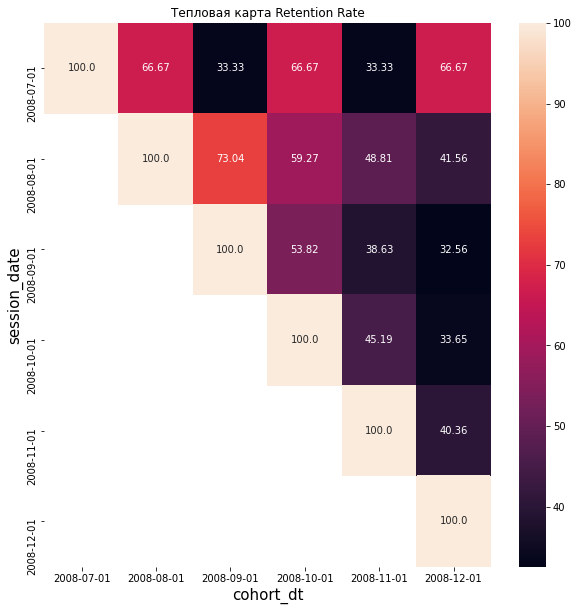

In [25]:
# постройте тепловую карту Retention Rate
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта Retention Rate') 
plt.xlabel('cohort_dt', fontsize = 15) 
plt.ylabel('session_date', fontsize = 15) 
plt.show()

In [26]:
# опишите аномалии или другие необычные явления и сформулируйте гипотезы

Для первой когорты (июльской) аномалии в удержании, то 66.67, то 33.33 и снова 66.67, возможно, это вызвано ошибками в данных.
Для остальных когорт идет уменьшение процента удержания по периодам, что уже больше соответствует действительности на практике.


# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [27]:
# напишите запрос
query = '''
WITH temp AS
(
SELECT EXTRACT(MONTH FROM creation_date)::int AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month
)
SELECT *,
       ROUND((posts_count::numeric/LAG(posts_count) OVER()-1)*100, 2) AS percentage
FROM temp;


'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

df

<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

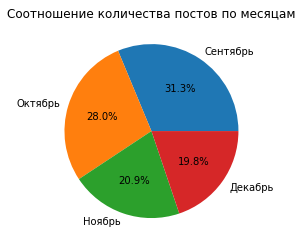

In [28]:
months = ["Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]

percentage = np.array(df['posts_count'])

plt.pie (percentage, labels = months, autopct='%1.1f%%')
plt.title ('Cоотношение количества постов по месяцам')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [29]:
# напишите запрос
query = '''
WITH base AS
(
SELECT user_id,
       COUNT(id)
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY COUNT(id) DESC
LIMIT 1
)
SELECT EXTRACT(WEEK FROM p.creation_date)::int AS week_creation,
       MAX(p.creation_date) AS creation_date
FROM base AS b
JOIN stackoverflow.posts AS p
ON b.user_id=p.user_id
WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-10-01'
GROUP BY week_creation;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)

In [30]:
df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>